In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# import tensorflow as tf
# from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy import stats

from models import *

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


In [42]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    # "DeltaQ_mins",
    # "DeltaQ_means",
    "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [43]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 8/80, loss: 533800.88
Epoch 16/80, loss: 117452.21
Epoch 24/80, loss: 101508.25
Epoch 32/80, loss: 59851.40
Epoch 40/80, loss: 32677.89
Epoch 48/80, loss: 17306.44
Epoch 56/80, loss: 17255.24
Epoch 64/80, loss: 15073.36
Epoch 72/80, loss: 12543.45
Epoch 80/80, loss: 11622.84
train 	 106.38778
test 	 106.08393
sec 	 340.32687


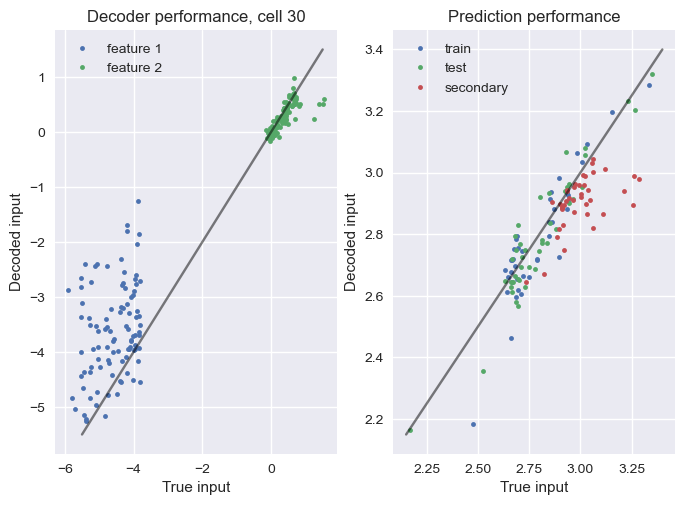


Stage 2:

Epoch 8/80, loss: 5.49
Epoch 16/80, loss: 2.68
Epoch 24/80, loss: 2.78
Epoch 32/80, loss: 2.37
Epoch 40/80, loss: 2.11
Epoch 48/80, loss: 2.02
Epoch 56/80, loss: 1.95
Epoch 64/80, loss: 1.87
Epoch 72/80, loss: 1.81
Epoch 80/80, loss: 1.75
train 	 75.09038
test 	 104.22835
sec 	 347.57837


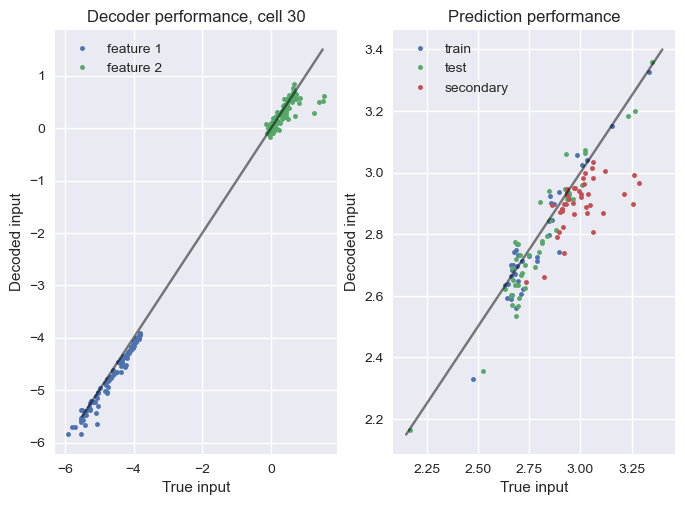


Stage 3:

Epoch 8/80, loss: 32217.90
Epoch 16/80, loss: 5459.61
Epoch 24/80, loss: 10712.56
Epoch 32/80, loss: 5435.81
Epoch 40/80, loss: 5348.33
Epoch 48/80, loss: 5333.07
Epoch 56/80, loss: 4967.18
Epoch 64/80, loss: 4726.00
Epoch 72/80, loss: 4576.02
Epoch 80/80, loss: 4460.11
train 	 66.66034
test 	 106.30375
sec 	 360.0051


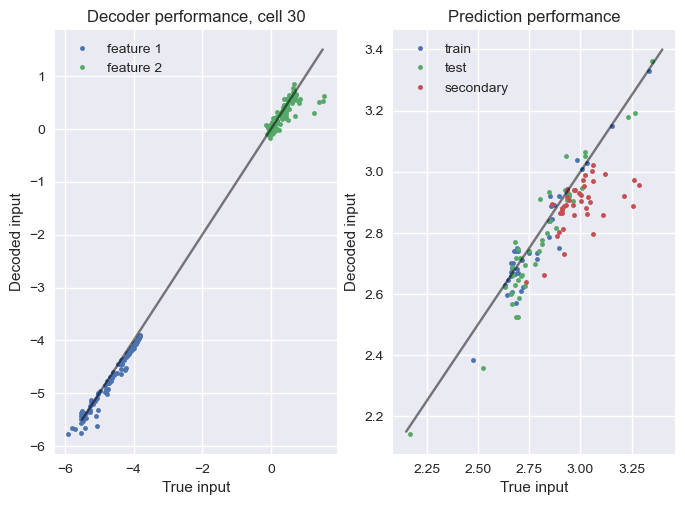

In [217]:
train_policy = {
    "num_stages": 3,
    "epochs": [80, 80, 80],
    "learning_rates": [5e-4, 5e-4, 5e-4],
    "batch_sizes": [64, 64, 64],
    "prediction_weights": [1, 0.0001, 1],
    "decoding_weights": [10, 1, 0.0001],
    "en_weights": [1, 1, 1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [218]:
model.encoder(x[5])

tensor([4.5870, 0.5113, 0.0000, 0.1877, 0.0000, 0.9413, 0.0000, 0.0000, 0.0000,
        0.7500, 0.0000, 3.2095, 0.0000, 0.0000, 0.0000, 0.0000, 3.5189, 3.3665,
        0.0000, 0.0000, 0.7879, 0.0000, 1.6995, 1.1177, 0.0000, 3.1115, 5.5519,
        0.0000, 2.6909, 0.0000, 0.0000, 1.8631], grad_fn=<ReluBackward0>)

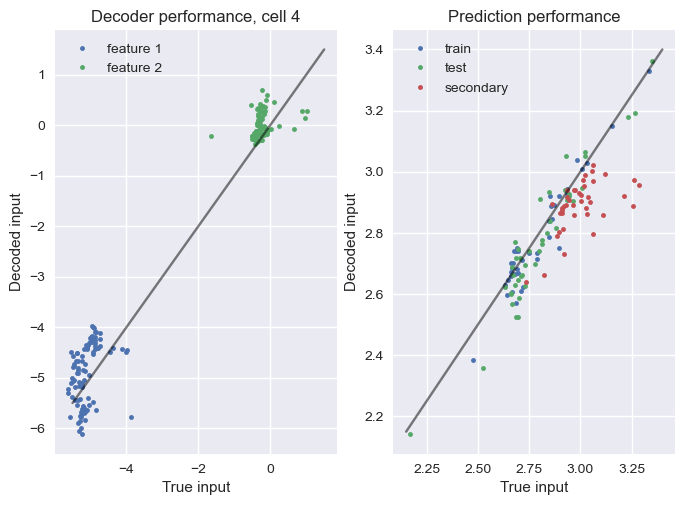

In [219]:
model.plotter(x, y, 4)

In [220]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3294], grad_fn=<AddBackward0>)


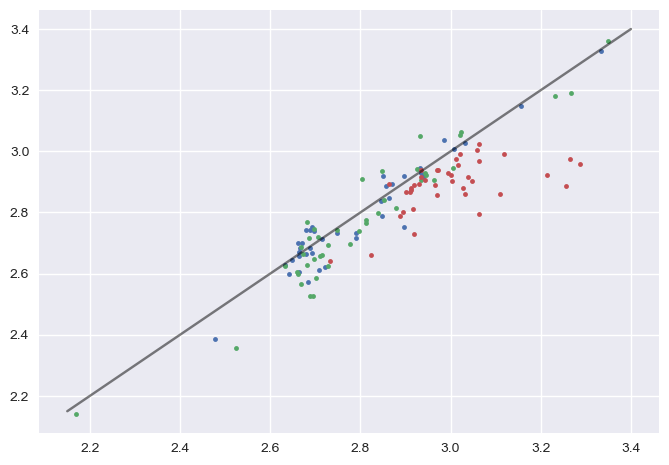

In [221]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [222]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[5.034599   0.59771323 0.         0.04501562 0.         1.1081419
 0.         0.         0.         0.7570978  0.         3.5552778
 0.         0.         0.         0.         4.0995407  3.6064954
 0.         0.         0.602447   0.         1.9323144  1.4230812
 0.         3.2964284  5.960352   0.         2.951986   0.
 0.         1.972801  ]


In [223]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [224]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, vdim=1, num_heads=1):
        super(AttentionModel, self).__init__()

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.d_model = d_model

    def reshape_input(self,X):
        return X.reshape(X.shape[0], -1)

    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, X):
        X = self.reshape_input(X)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        attn_output = self.scaled_dot_product_attention(Q, K, V)
        return attn_output

In [239]:
# parameters
lr = 0.0005
feat_dim = 2*16
d_model = 16
nepoch = 3000
batch_size = 1

In [240]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  640.770 | rmse_test:  660.114 | rmse_stest:  1063.915
Epochs: 100 | rmse:  628.395 | rmse_test:  642.965 | rmse_stest:  1062.003
Epochs: 150 | rmse:  623.046 | rmse_test:  627.645 | rmse_stest:  1058.937
Epochs: 200 | rmse:  617.250 | rmse_test:  621.170 | rmse_stest:  1055.988
Epochs: 250 | rmse:  611.706 | rmse_test:  632.554 | rmse_stest:  1050.215
Epochs: 300 | rmse:  609.033 | rmse_test:  635.533 | rmse_stest:  1045.361
Epochs: 350 | rmse:  606.677 | rmse_test:  633.043 | rmse_stest:  1039.023
Epochs: 400 | rmse:  603.727 | rmse_test:  632.952 | rmse_stest:  1031.071
Epochs: 450 | rmse:  599.371 | rmse_test:  631.669 | rmse_stest:  1020.602
Epochs: 500 | rmse:  588.495 | rmse_test:  647.469 | rmse_stest:  1000.110
Epochs: 550 | rmse:  580.677 | rmse_test:  652.195 | rmse_stest:  977.695
Epochs: 600 | rmse:  574.164 | rmse_test:  639.349 | rmse_stest:  954.330
Epochs: 650 | rmse:  566.058 | rmse_test:  599.714 | rmse_stest:  938.251
Epochs: 700 | rmse:  556.660 

In [233]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

60.40980926064341
94.53446667421667
330.8848630922992


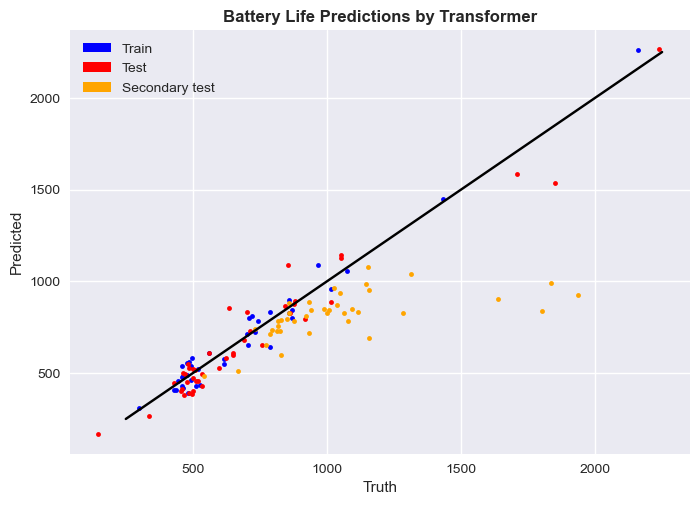

In [234]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)